# Imports

In [ ]:
import os 
path = os.getcwd()
%matplotlib inline
if path[1:5] == "Home":
    %run /Home/siv30/wad005/master/GRB/src/paths/uib.ipynb
    %run /Home/siv30/wad005/master/GRB/src/harvest_matlab_data.ipynb
    %run /Home/siv30/wad005/master/GRB/src/convert_erg.ipynb
    %run /Home/siv30/wad005/master/GRB/src/ASIMXspec.ipynb
else:
    %run /Users/andreas/phys/master/GRB/src/paths/mac.ipynb # Mac paths
    %run /Users/andreas/phys/master/GRB/src/harvest_matlab_data.ipynb
    %run /Users/andreas/phys/master/GRB/src/convert_erg.ipynb
    %run /Users/andreas/phys/master/GRB/src/ASIMXspec.ipynb

# Notes
    tlagg = 0.472 s

# Background extraction

In [64]:
tlagg = 0.476 #s
T0 = datetime.fromisoformat('2019-03-05T13:05:19.816')
T0 += timedelta(seconds=tlagg)
df = harvest_data(fn='2019_3_5_13_5_19',T0='2019-03-05T13:05:19.816')
df['tus'] += tlagg
tus = df['tus'].to_numpy()
len(tus),type(tus)

dau/det starting from index 1
tus array given in seconds
safety time:  0.175 % removed
sorted by tus (s)


(42182, numpy.ndarray)

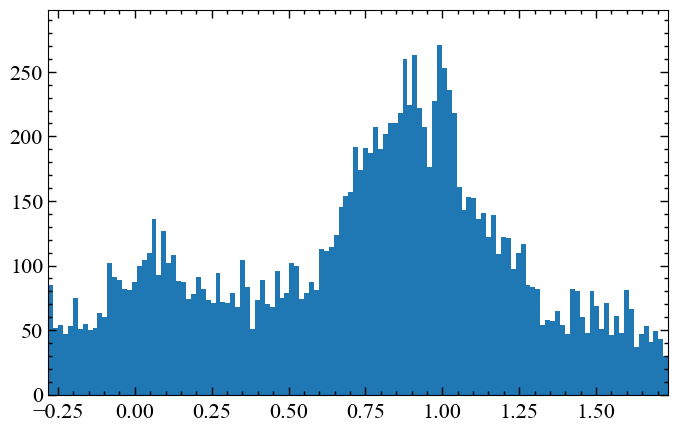

In [65]:
binsize = 0.016
i,j=np.searchsorted(tus,-2),np.searchsorted(tus,2)
bins = np.arange(min(tus[i:j]),max(tus[i:j])+binsize,binsize)
plt.hist(tus[i:],bins=bins)
plt.show()

In [66]:
df_asim_burst = df.truncate(before=i,after=j-1)
tus_burst =df_asim_burst['tus'].to_numpy()
print(tus_burst[0],tus_burst[-1])

-0.28140672200000005 1.7272319170000001


last bkg bin: -0.1054


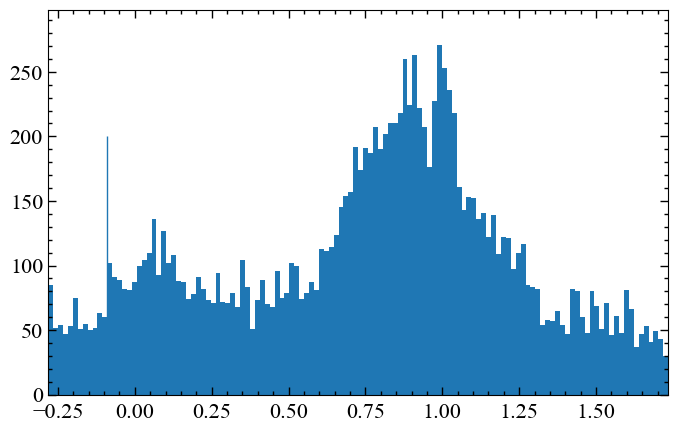

In [67]:
bins_burst = np.arange(min(tus_burst),max(tus_burst)+binsize,binsize)
plt.hist(tus_burst,bins=bins_burst)
plt.vlines(x=bins_burst[12],ymin=0,ymax=200)
print(f'last bkg bin: {round(bins_burst[11],4)}')
plt.show()

In [68]:
jx = df_asim_burst.index[0] + np.searchsorted(tus_burst,bins_burst[11])
df_asim_bkg = df_asim_burst.truncate(after=jx)
df_asim_burst = df_asim_burst.truncate(before=jx)
tus_bkg = df_asim_bkg['tus'].to_numpy()
tus_burst = df_asim_burst['tus'].to_numpy()

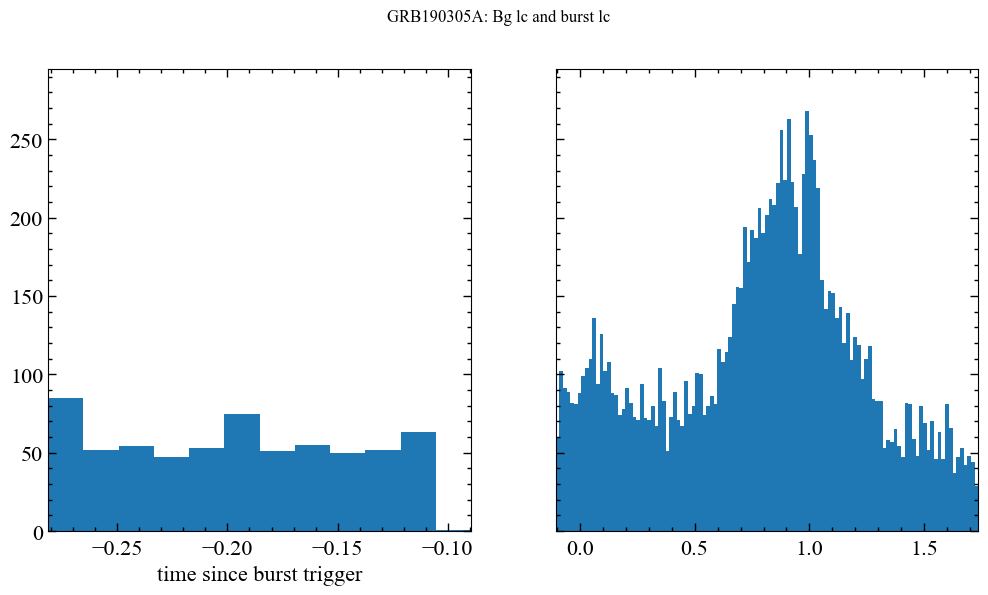

In [69]:
fig, (ax1, ax2) = plt.subplots(1, 2,sharey=True,figsize=(12, 6))
fig.suptitle('GRB190305A: Bg lc and burst lc')
ax1.hist(tus_bkg,bins=np.arange(min(tus_bkg),max(tus_bkg)+binsize,binsize))
ax2.hist(tus_burst,bins=np.arange(min(tus_burst),max(tus_burst)+binsize,binsize))
ax1.set_xlabel("time since burst trigger")
plt.show()

# Cross Corrolation of burst LC

In [52]:
#calculating the tlagg approx based on trigger times and ToF
#bringing into KW ref frame...
#T0_ASIM = 13:05:19.816 abs time correction accounted for
#T0_KW = 13:05:15:900
#ToF = 3.4460
tlagg_approx = np.round(19.816-15.900-3.4460,3)
print(tlagg_approx)

0.47


### KW

In [ ]:
kw_filename = "GRB190305A_2ms.txt"
kw_file = kw_lc_path + kw_filename
binsize=0.002

kw_df = pd.read_csv(kw_file,sep='\s+')
kw_bin_lo,kw_bin_hi,G1,G2,G3= kw_df["Ti"].to_numpy(dtype=np.float16), kw_df["Tf"].to_numpy(dtype=np.float16),kw_df["G1"].to_numpy(dtype=np.float16), kw_df["G2"].to_numpy(dtype=np.float16), kw_df["G3"].to_numpy(dtype=np.float16)

#kw_dt = np.round(np.diff(kw_bin_lo),3)
#i_stop_kw = np.where(kw_dt>2*binsize)[0][0]

#cutting LC at T0+1.5 s, so that both LC's have 2s of data
i_start_kw = find_nearest(kw_bin_lo,-0.25)
print(kw_bin_lo[i_start_kw])
i_stop_kw = find_nearest(kw_bin_lo,1.5)
print(kw_bin_lo[i_stop_kw])


kw_bin_lo, kw_bin_hi, G1, G2, G3 = kw_bin_lo[i_start_kw:i_stop_kw], kw_bin_hi[i_start_kw:i_stop_kw], G1[i_start_kw:i_stop_kw],G2[i_start_kw:i_stop_kw], G3[i_start_kw:i_stop_kw]
kwCounts = G3
kw_lc = LC(time=np.round(kw_bin_lo + binsize/2,3), counts=kwCounts, skip_checks=True,dt=binsize)
kw_lc.plot()

### HED

In [60]:
df_burst['tus'].to_numpy()

array([-757406.722, -755353.222, -754378.028, ..., 1248033.667,
       1249335.332, 1249338.167])

In [ ]:
tus_burst = df_burst['tus'].to_numpy()/1e6 #converting back to seconds for CC
tus_burst += tlagg_approx
hist = np.histogram(tus_burst,bins=np.append(kw_bin_lo,kw_bin_hi[-1])) #using KW bins
asimCounts,asimEdges = hist[0],hist[1]

plt.step(x=asimEdges[:-1],y=asimCounts,where="post")
plt.title("ASIM")
plt.show()

In [ ]:
asim_lc = LC(time=np.round(kw_bin_lo + binsize/2,3), counts=asimCounts, skip_checks=True,dt=binsize)
asim_lc.plot()
kw_lc.plot()

In [ ]:
CC = CrossCorrelation(kw_lc,asim_lc,mode="full")
CClagg=CC.time_shift
tlagg = tlagg_approx + CClagg
print("Total lagg (s): ", tlagg, "| CC lagg: ", CClagg, '  tlagg_approx: ', tlagg_approx)
CC.plot()

In [64]:
tlagg = 0.476
df_burst['tus'] = df_burst['tus'].to_numpy() + tlagg*1e6

In [ ]:
plot_HED(tus_arr=df_burst['tus'].to_numpy(),binsize=16,T0=T0+timedelta(seconds=tlagg))

In [ ]:
df_burst.head()

# SPECTRUM

### BACKGROUND

In [70]:
df_keV_bg = keV_hist(df_asim_bkg,time_interval='max',keV_interval='max')

Computing whole spectrum (10-1e5 keV)
n triggers in time interval  637
n triggers are within bounds  637
keV bins are set for HED
Energies binned!


In [71]:
df_keV_bg.tail()

,bins_keV,counts,poisson_error_counts
36,39810.72,32,5.656854
37,50118.72,1,1.000000
38,63095.73,0,0.000000
39,79432.82,0,0.000000
40,100000.00,0,0.000000


### BURST

In [90]:
df_keV_burst = keV_hist(df_asim_burst,time_interval=(0.768,1.280),keV_interval='max')

Computing whole spectrum (10-1e5 keV)
n triggers in time interval  5753
n triggers are within bounds  5753
keV bins are set for HED
Energies binned!


In [ ]:
df_keV_burst.head(40)

# FITS

In [75]:
%run /Home/siv30/wad005/master/GRB/xspec/ASIM/ASIMFits/BAK/ASIMbak.ipynb
%run /Home/siv30/wad005/master/GRB/xspec/ASIM/ASIMFits/PHA/ASIMpha.ipynb
%run /Home/siv30/wad005/master/GRB/xspec/ASIM/ASIMFits/RSP/ASIMrsp.ipynb
%run /Home/siv30/wad005/master/GRB/xspec/ASIM/ASIMFits/RSP/find_closest_DRM.ipynb

## BAK

In [76]:
print(T0)
print(min(df_asim_bkg['tus'].to_numpy()),max(df_asim_bkg['tus'].to_numpy()))

2019-03-05 13:05:20.292000
-0.28140672200000005 -0.10535463900000008


In [79]:
#EXPOSURE
print(max(df_asim_bkg['tus'].to_numpy())-min(df_asim_bkg['tus'].to_numpy()))

0.17605208299999997


In [78]:
ra,dec=340.399,-10.588

In [80]:
BAK_dict = {
    'USER': ['Andreas Ramsli','Username of creator of this fits file'], #<str>
    'T0TIME':['2019-03-05T13:05:20.292','Trigger time UT format=YYYY-MM-DDThh:mm:ss.fff'], #<str> 
    'TSTART': [-0.2814,'[s] Start time of background spectrum accumulation'], #<float> [s] Start time of spectrum accumulation relative to T0TIME
    'TSTOP': [-0.1053,'End time of background spectrum accumulation'], #<float> [s]
    'EXPOSURE': [0.176052,'[s] Integration time in seconds for the BAK data'], #<float> 
    'OBJECT': ['GRB190305A','Name of the observed object'], #<str> 
    'RA_OBJ': [340.399,'[deg] RA of source'], #<float> 
    'DEC_OBJ':  [-10.588,'[deg] Dec of source'], #<float>
    'FILENAME': ['HED_GRB190305A.bak','Backgorund filename for fits file'] #<str>  ('example.bak')
}


In [81]:
generateBAK(BAK_dict=BAK_dict,
            bakCounts=df_keV_bg['counts'][1:].to_numpy(dtype=np.int32),
            stat_err=df_keV_bg['poisson_error_counts'][1:].to_numpy(dtype=np.float32),
            bin_lo=df_keV_bg['bins_keV'][:-1].to_numpy(dtype=np.float32),
            bin_hi=df_keV_bg['bins_keV'][1:].to_numpy(dtype=np.float32)
           )

## PHA

In [91]:
PHA_dict = {
    'USER': ['Andreas Ramsli','Username of creator of this fits file'], #<str>
    'T0TIME':['2019-03-05T13:05:20.292','Trigger time UT format=YYYY-MM-DDThh:mm:ss.fff'], #<str> 
    'TSTART': [0.768,'[s] Start time of spectrum accumulation'], #<float> [s] Start time of spectrum accumulation relative to T0TIME
    'TSTOP': [1.280,'End time of spectrum accumulation'], #<float> [s]
    'EXPOSURE': [0.512,'[s] Integration time in seconds for the PHA data'], #<float> 
    'OBJECT': ['GRB190305A','Name of the observed object'], #<str> 
    'RA_OBJ': [340.399,'[deg] RA of source'], #<float> 
    'DEC_OBJ':  [-10.588,'[deg] Dec of source'], #<float>
    'BACKFILE': ['HED_GRB190305A.bak','Background FITS file'], #<str> ('example.bak')
    'RESPFILE': ['HED_GRB190305A.rsp','Response FITS file'], #<str> ('example.rsp')
    'FILENAME': ['HED_GRB190305A.pha','PHA filename'] #<str>  ('example.pha')
}


In [92]:
generatePHA(PHA_dict=PHA_dict,
            counts=df_keV_burst['counts'][1:].to_numpy(dtype=np.int16),
            stat_err=df_keV_burst['poisson_error_counts'][1:].to_numpy(dtype=np.float32),
            bin_lo=df_keV_burst['bins_keV'][:-1].to_numpy(dtype=np.float32),
            bin_hi=df_keV_burst['bins_keV'][1:].to_numpy(dtype=np.float32))

### RSP
    Used from theta,phi angles

In [93]:
theta,phi=133.904,-2.076

In [ ]:
find_DRM_file(dir_path='/Users/andreas/phys/master/HED_DRM/',
             theta=theta,phi=phi)

In [95]:
RSP_dict = {
    'USER': ['Andreas Ramsli','Username of creator of this fits file'], #<str>
    'T0TIME':['2019-03-05T13:05:20.292','Trigger time UT format=YYYY-MM-DDThh:mm:ss.fff'], #<str> 
    'TSTART': [0.768,'[s] Start time of spectrum accumulation'], #<float> [s] Start time of spectrum accumulation relative to T0TIME
    'TSTOP': [1.280,'End time of spectrum accumulation'], #<float> [s]
    'EXPOSURE': [0.512,'[s] Integration time in seconds for the PHA data'], #<float> 
    'OBJECT': ['GRB190305A','Name of the observed object'], #<str> 
    'RA_OBJ': [340.399,'[deg] RA of source'], #<float> 
    'DEC_OBJ':  [-10.588,'[deg] Dec of source'], #<float>
    'FILENAME': ['HED_GRB190305A.rsp','RSP filename'] #<str>  ('example.pha')
}

In [96]:
generateRSP(RSP_dict=RSP_dict, 
            DRM_fname='HED_drm_mats_135.00_0.00.txt', 
            bin_lo=df_keV_burst['bins_keV'][:-1].to_numpy(dtype=np.float32),
            bin_hi=df_keV_burst['bins_keV'][1:].to_numpy(dtype=np.float32),
            theta=theta,
            phi=phi,
            see_headers=False)